In [1]:
%pip install --quiet jupysql ipywidgets ipympl duckdb duckdb-engine pandas matplotlib jupyterlab

Note: you may need to restart the kernel to use updated packages.


In [2]:
import duckdb
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
%load_ext sql
%matplotlib widget

In [3]:
%config SqlMagic.autopandas = True
%config SqlMagic.displaycon = False

In [4]:
%sql duckdb:///./380406.duckdb

Connecting to 'duckdb:///./380406.duckdb'

In [5]:
%sqlcmd tables

Name
Gateway
Site
Node
Message
Trace
Radio
Power_Consumption
Downlink_Event_Error_Message
Join_Message
Content_Message


In [6]:
%sql select * from Trace

,trace_id,node_id,timestamp,message
0,1,70B3D57ED005EA59,2023-10-05 14:12:05.397668,�3#�NebulaStream End Device Runtime (Build Dat...
1,2,70B3D57ED005EA59,2023-10-05 14:12:05.400559,=====================================\n
2,3,70B3D57ED005EA59,2023-10-05 14:12:05.414474,"Initializing enabled sensors...Sensor: hts221,..."
3,4,70B3D57ED005EA59,2023-10-05 14:12:05.417547,"Sensor: hts221, type: 130\n"
4,5,70B3D57ED005EA59,2023-10-05 14:12:05.419485,"Sensor: hts221, type: 131\n"
...,...,...,...,...
638,639,70B3D57ED005EA55,2023-10-05 14:15:31.285982,collecting data from sensor hts221\n
639,640,70B3D57ED005EA55,2023-10-05 14:15:31.288996,collecting data from sensor lps22hb\n
640,641,70B3D57ED005EA55,2023-10-05 14:15:31.292002,Execute Queries...\n
641,642,70B3D57ED005EA55,2023-10-05 14:15:31.292842,Sending: <3\n


In [7]:
%sql nodes =<< select distinct * from Node

,node_deveui,node_appeui,node_appkey,board_id,radio_chipset,node_site,profile,riot_board
0,70B3D57ED005E88A,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1
1,70B3D57ED005EA56,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1
2,70B3D57ED005EA55,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1
3,70B3D57ED005EA57,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1
4,70B3D57ED005EA59,0000000000000000,385794DDE70CE2EAB5B5B12A4807822C,st-lrwan1,sx1276,saclay,stm32Profile,b-l072z-lrwan1


In [8]:

timestamps=%sql select timestamp from Power_Consumption 
#timestamps = timestamps["timestamp"].map(lambda x: x.isoformat())
%sql SUMMARIZE Power_Consumption

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,power_consumption_id,INTEGER,1,90233,89924,45117.0,26048.167757061146,22559,45117,67675,90233,0.0%
1,node_id,VARCHAR,70B3D57ED005E88A,70B3D57ED005EA59,5,None,None,None,None,None,90233,0.0%
2,timestamp,TIMESTAMP,2023-10-05 14:12:00.084675,2023-10-05 14:14:40.532677,91275,None,None,None,None,None,90233,0.0%
3,current,FLOAT,0.054332,0.104806,862,0.05877981105106328,0.008970661660353752,0.0558157787280278,0.05635755704084524,0.05706828527472678,90233,0.0%
4,voltage,FLOAT,4.84375,5.02625,42,4.927202074709501,0.0784952962434207,4.863737324186305,4.868750095367432,5.022500038146973,90233,0.0%
5,power,FLOAT,0.230758,0.526226,333,0.2896481934519649,0.04477112120476466,0.2742030811122251,0.2783749997615814,0.28246717887936856,90233,0.0%


In [9]:
%sql select node_id,count(*),min(timestamp),max(timestamp) from Power_Consumption group by node_id

,node_id,count_star(),"min(""timestamp"")","max(""timestamp"")"
0,70B3D57ED005EA55,6810,2023-10-05 14:12:00.409122,2023-10-05 14:12:30.662848
1,70B3D57ED005EA57,6939,2023-10-05 14:12:00.232541,2023-10-05 14:12:30.398112
2,70B3D57ED005E88A,13478,2023-10-05 14:12:00.084675,2023-10-05 14:13:00.940262
3,70B3D57ED005EA59,26686,2023-10-05 14:12:00.214605,2023-10-05 14:14:01.276958
4,70B3D57ED005EA56,36320,2023-10-05 14:12:00.410794,2023-10-05 14:14:40.532677


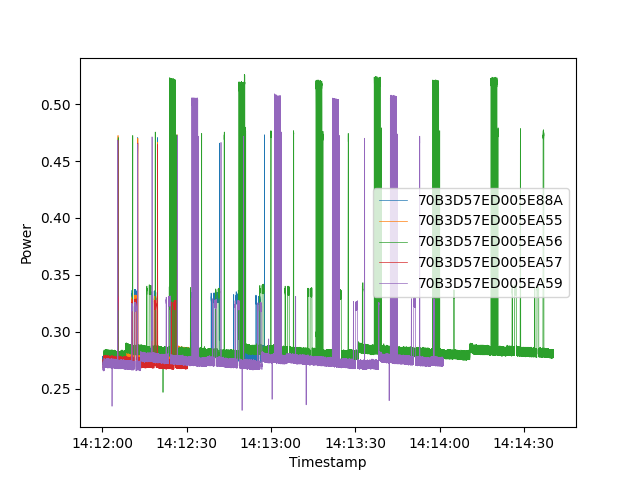

In [10]:
deveui = "70B3D57ED005EA56"

power= %sql select timestamp,power,current,voltage,node_id from Power_Consumption
#plot power with timestamps as x axis. timestamps need to show milliseconds
plt.clf()
for node_id, group in power.groupby("node_id"):
    plt.plot(group["timestamp"], group["power"], label=node_id, linewidth=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Power")
plt.legend()
plt.show()

In [11]:
%sql select * from Trace where node_id LIKE '70B3D57ED005E88A'

,trace_id,node_id,timestamp,message
0,10,70B3D57ED005E88A,2023-10-05 14:12:05.430226,�=�NebulaStream End Device Runtime (Build Date...
1,11,70B3D57ED005E88A,2023-10-05 14:12:05.434223,=====================================\n
2,12,70B3D57ED005E88A,2023-10-05 14:12:05.448352,"Initializing enabled sensors...Sensor: hts221,..."
3,13,70B3D57ED005E88A,2023-10-05 14:12:05.451269,"Sensor: hts221, type: 130\n"
4,15,70B3D57ED005E88A,2023-10-05 14:12:05.453266,"Sensor: hts221, type: 131\n"
...,...,...,...,...
93,584,70B3D57ED005E88A,2023-10-05 14:15:11.087421,collecting data from sensor hts221\n
94,585,70B3D57ED005E88A,2023-10-05 14:15:11.091471,collecting data from sensor hts221\n
95,586,70B3D57ED005E88A,2023-10-05 14:15:11.095454,collecting data from sensor lps22hb\n
96,587,70B3D57ED005E88A,2023-10-05 14:15:11.097372,Execute Queries...\n


In [12]:
# lower=widgets.SelectionSlider(options=timestamps, value=timestamps.min())
# upper=widgets.SelectionSlider(options=timestamps, value=timestamps.max())
# %sql --save hej --interact deveuis --interact lower --interact upper SELECT * from Power_Consumption where node_id LIKE '{{deveuis}}' AND timestamp BETWEEN '{{lower}}' AND '{{upper}}'